### Тестирование алгоритмов обнаружения разладки на искусственных данных

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import math
import cvxpy as cvx
from sklearn.linear_model import LogisticRegression
import torch
from torch import nn
from tqdm import tqdm

torch.manual_seed(1)


%matplotlib inline

## Алгоритмы обнаружения разладки

### Метод, основанный на вычислении M-статистики

S. Li, Y. Xie, H. Dai, and L. Song, "M-statistic for kernel change-point detection” (NIPS, 2015)

In [2]:
# Функция для подсчета U-статистики
def mmd_squared(X, Y, sigma):
    
    # Объем выборки
    n = X.shape[0]
    
    # Попарные расстояния
    xx_dist = pairwise_distances(X)
    xy_dist = pairwise_distances(X, Y)
    yy_dist = pairwise_distances(Y)
    
    # Значения ядра
    xx_kernel = np.exp(-0.5 * (xx_dist / sigma)**2) - np.identity(n)
    xy_kernel = np.exp(-0.5 * (xy_dist / sigma)**2) - np.identity(n)
    yy_kernel = np.exp(-0.5 * (yy_dist / sigma)**2) - np.identity(n)
    
    # Подсчет U-статистики
    u_stat = (np.sum(xx_kernel) - 2 * np.sum(xy_kernel) + np.sum(yy_kernel)) / n / (n - 1)
    
    return u_stat
    
# Вспомогательная функция для подсчета оценки дисперсии    
def h_squared(X, sigma):
    
    # Объем выборки
    n = X.shape[0]
    
    # Разбиваем наблюдения на 4 подвыборки
    n_max = 4 * (n // 4)
    X_1 = X[0:n_max:4]
    X_2 = X[1:n_max:4]
    X_3 = X[2:n_max:4]
    X_4 = X[3:n_max:4]
    
    K_12 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_2, axis=1) / sigma)**2)
    K_13 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_3, axis=1) / sigma)**2)
    K_24 = np.exp(-0.5 * (np.linalg.norm(X_2 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    return np.mean((K_12 - K_13 - K_24 + K_34)**2)


# Вспомогательная функция для подсчета оценки дисперсии    
def h_cov(X, sigma):
    
    # Объем выборки
    n = X.shape[0]
    
    # Разбиваем наблюдения на 6 подвыборок
    n_max = 6 * (n // 6)
    X_1 = X[0:n_max:6]
    X_2 = X[1:n_max:6]
    X_3 = X[2:n_max:6]
    X_4 = X[3:n_max:6]
    X_5 = X[4:n_max:6]
    X_6 = X[5:n_max:6]
    
    K_12 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_2, axis=1) / sigma)**2)
    K_13 = np.exp(-0.5 * (np.linalg.norm(X_1 - X_3, axis=1) / sigma)**2)
    K_24 = np.exp(-0.5 * (np.linalg.norm(X_2 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    K_56 = np.exp(-0.5 * (np.linalg.norm(X_5 - X_6, axis=1) / sigma)**2)
    K_53 = np.exp(-0.5 * (np.linalg.norm(X_5 - X_3, axis=1) / sigma)**2)
    K_64 = np.exp(-0.5 * (np.linalg.norm(X_6 - X_4, axis=1) / sigma)**2)
    K_34 = np.exp(-0.5 * (np.linalg.norm(X_3 - X_4, axis=1) / sigma)**2)
    
    # Второе слагаемое в оценке дисперсии
    h_1234 = K_12 - K_13 - K_24 + K_34
    h_5634 = K_56 - K_53 - K_64 + K_34
    
    return np.mean((h_1234 - np.mean(h_1234)) * (h_5634 - np.mean(h_5634)))


# Оценка дисперсии
def estimate_variance(X, window_size, sigma):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
        
    # Объем выборки
    n = X.shape[0]
    
    # Первое слагаемое в оценке дисперсии
    h2 = h_squared(X, sigma) 
    
    # Второе слагаемое в оценке дисперсии
    h_c = h_cov(X, sigma)
    
    # Оценка дисперсии
    var = 2 * (h2 + h_c) / window_size / (window_size - 1)
        
    return np.maximum(var, 1e-5)


# Функция для вычисления тестовой статистики
#
# X -- массив наблюдений
#
# window_size -- ширина скользящего окна
#
# sigma -- параметр сглаживания, bandwidth
#
# threshold -- критическое значение
#
def compute_test_stat_mmd(X, window_size=10, sigma=0.1, threshold=math.inf):
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    b = window_size
    
    # Объем выборки
    n = X.shape[0]
    
    # Инициализация
    T = np.zeros(n)
    stopping_time = -1
    
    for t in range(2*b + 1, n):
        
        # Тестовая часть
        X_te = X[t-b:t, :]
        # Референсная часть
        X_re = X[t-2*b:t-b, :]
        
        # Вычисление меры расхождения
        MMD_2 = mmd_squared(X_re, X_te, sigma)
        # Оценка дисперсии
        var = estimate_variance(X_re, window_size, sigma)
        
        # Вычисление тестовой статистики
        T[t] = MMD_2 / np.sqrt(var)
        
        # Если тестовая статистика превышает критическое значение,
        # остановить процедуру
        if T[t] > threshold:
        
            stopping_time = t
            break
    
    if stopping_time != -1:
        T = T[:stopping_time + 1]
    
    return T, stopping_time

### KLIEP, uLSIF, RuLSIF

M. Sugiyama, T. Suzuki, S. Nakajima, H. Kashima, P. von Bunau, and M. Kawanabe, "Direct importance estimation for covariate shift adaptation" (Ann. Inst. Appl. Math., 2008);

T. Kanamori, S. Hido, and M. Sugiyama, "A least-squares approach to direct importance estimation", (J. Mach. Learn. Res., 2009);

M. Yamada, T. Suzuki, T. Kanamori, H. Hachiya, and M. Sugiyama, "Relative density-ratio estimation for robust distribution comparison" (Neural Computation, 2013)

In [3]:
# Вспомогательная функция для вычисления меры расхождения между
# тестовой частью наблюдений X_te и референсной X_re
#
def divergence(X_te, X_re, sigma, method='kliep', alpha=0.5):
    
    # Длина тестового участка временного ряда
    n_te = X_te.shape[0]
    # Длина референсного участка временного ряда
    n_re = X_re.shape[0]
    
    # Попарные расстояния
    te_te_dist = pairwise_distances(X_te)
    re_te_dist = pairwise_distances(X_re, X_te)
    
    # Подсчет ядра
    te_te_kernel = np.exp(-0.5 * (te_te_dist / sigma)**2)
    re_te_kernel = np.exp(-0.5 * (re_te_dist / sigma)**2)
    
    # Переменная, по которой производится оптимизация
    theta = cvx.Variable(n_te)
    
    # Целевая функция и ограничения
    if method == 'kliep':
        obj = cvx.Maximize(cvx.sum(cvx.log(te_te_kernel @ theta)))
        constraints = [cvx.sum(re_te_kernel @ theta) == n_re, theta >= 0]
    elif method == 'ulsif':
        obj = cvx.Minimize(0.5 * cvx.sum((re_te_kernel @ theta)**2) - cvx.sum(te_te_kernel @ theta))
        constraints = []
    elif method == 'rulsif':
        obj = cvx.Minimize(0.5 * alpha * cvx.sum((te_te_kernel @ theta)**2)\
                           + 0.5 * (1 - alpha) * cvx.sum((re_te_kernel @ theta)**2)\
                           - cvx.sum(te_te_kernel @ theta))
        constraints = []
    
    # Задача оптимизации
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver='SCS', eps=1e-2)
    
    # Вычисление оценки меры расхождения
    if method == 'kliep':
        test_stat = np.mean(te_te_kernel @ theta.value)
        
    elif method == 'ulsif':
        test_stat = -0.5 * np.mean((re_te_kernel @ theta.value)**2) + np.mean(te_te_kernel @ theta.value) - 0.5
        
    elif method == 'rulsif':
        test_stat = -0.5 * alpha * np.mean((te_te_kernel @ theta.value)**2)\
        - 0.5 * (1 - alpha) * np.mean((re_te_kernel @ theta.value)**2) + np.mean(te_te_kernel @ theta.value) - 0.5
    
    return test_stat

# Функция для вычисления тестовой статистики
#
# X -- массив наблюдений
#
# window_size -- ширина скользящего окна
#
# sigma -- параметр сглаживания, bandwidth
#
# threshold -- критическое значение
#
# method -- один из трех методов: kliep, ulsif, rulsif
#
# alpha -- параметр, использующийся только в rulsif; определяет меру расхождения
#
def compute_divergence_test_stat(X, window_size=10, sigma=0.1, threshold=math.inf, method='kliep', alpha=0.5):
    
    if (method not in ['kliep', 'ulsif', 'rulsif']):
        raise ValueError()
    
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    
    b = window_size
    
    # Объем выборки
    n = X.shape[0]
    
    # Инициализация
    T = np.zeros(n)
    stopping_time = -1
    
    for t in range(2*b + 1, n):
        
        # Тестовая часть
        X_te = X[t-b:t]
        # Референсная часть
        X_re = X[t-2*b:t-b]
        
        T[t] = 0.5 * (divergence(X_te, X_re, sigma, method=method, alpha=alpha)\
                      + divergence(X_re, X_te, sigma, method=method, alpha=alpha))
        
        # Если тестовая статистика превышает критическое значение,
        # остановить процедуру
        if T[t] > threshold:
        
            stopping_time = t
            break
    
    if stopping_time != -1:
        T = T[:stopping_time + 1]
    
    return T, stopping_time

### CUSUM

In [4]:
# Функция для вычисления тестовой статистики
#
# X -- массив наблюдений
#
def compute_cusum(X):
    
    # Инициализация
    T = np.zeros(X.shape[0])
    
    for n in range(1, X.shape[0]):
        
        t = np.zeros(n)
        
        for k in range(1, n):
            t[k] = abs((n - k) * X[:k].sum()   - k * X[k:n].sum() ) / np.sqrt(n * k * (n - k))
        
        # Тестовая статистика
        T[n] = np.max(t)
    
    return T

### Контрастный метод

N. Puchkin and V. Shcherbakova, "A Contrastive Approach to Online Change Point Detection" (AISTATS, 2023)

In [5]:
#------------------------------------------------------------------------------
# Версия алгоритма с линейным референсным классом функций
#------------------------------------------------------------------------------


# Вспомогательные функции для вычисления матриц дизайна
def compute_design_poly(X, p):
    
    n = X.shape[0]
    Psi = np.power(np.outer(X, np.ones(p)), np.outer(np.ones(n), np.arange(p)))
    
    return Psi
    
    
def compute_design_Fourier(X, p):
    res = np.zeros((p, X.shape[0]))
    res[0] = np.ones(X.shape[0]) / np.sqrt(2)
    T = 1
    for i in range(1, p):
        if (i // 2 == 0):
            res[i] = np.sin(X * 2 * np.pi * i / T) / np.sqrt(T / 2)
        else:
            res[i] = np.cos(X * (2 * np.pi * i) / T) / np.sqrt(T / 2)
    return res.T


def compute_design_multivariate(X):
    
    Psi = np.append(np.ones((X.shape[0], 1)), X, axis=1)
    
    return Psi
    
    
# Вспомогательная функция для оценки значения параметра
def compute_theta(Psi, tau):
    
    # Sample size
    t = Psi.shape[0]
    
    # Create "virtual" labels
    Y = np.append(np.ones(tau), -np.ones(t - tau))
    
    lr = LogisticRegression(penalty='none', fit_intercept=False, tol=1e-2,\
                            solver='lbfgs', class_weight='balanced', n_jobs=-1)
    lr.fit(Psi, Y)
    theta = (lr.coef_).reshape(-1)
    
    return theta
    
    
# Вычисление тестовой статистики
def compute_test_stat_linear(X, p, t_min=20, n_out_min=10, B=10, delta_max=150, design="poly", threshold=math.inf):
    
    # Объем выборки
    n = X.shape[0]
    
    # Вычисление матрицы дизайна
    if design == "poly":
        Psi = compute_design_poly(X, p)
    elif design == "fourier":
        Psi = compute_design_Fourier(X, p)
    elif design == "multivariate":
        Psi = compute_design_multivariate(X)
        p = X.shape[1] + 1
    else:
        raise ValueError()
    
    # Инициализация
    T = np.zeros((n, n))
    S = np.zeros(n)
    
    stopping_time = -1

    for t in range(t_min, n):
        
        D = np.zeros(t)
        
        for tau in range(np.maximum(n_out_min, t - n_out_min - delta_max), t-n_out_min):
            
            # Вычисление оценки параметра theta
            theta = compute_theta(Psi[:t, :], tau)
            Z = Psi[:t, :] @ theta
            
            # Для избежания проблем с возведением в степень
            Z = np.minimum(Z, B)
            Z = np.maximum(Z, -B)
            
            D[:tau] = 2 / (1 + np.exp(-Z[:tau]))
            D[tau:] = 2 / (1 + np.exp(Z[tau:]))
            D = np.log(D)
            
            T[tau, t] = tau * (t - tau) / t * (np.mean(D[:tau]) + np.mean(D[tau:]))
            
        # Если тестовая статистика превышает критическое значение,
        # остановить процедуру
        S[t] = np.max(T[:, t])
        if S[t] > threshold:
        
            stopping_time = t
            break
            
    if stopping_time != -1:
        S = S[:stopping_time + 1]
    
    return S, stopping_time

In [6]:
# Архитектура нейронной сети
#
class NN(nn.Module):
    def __init__(self, n_in, n_out):
        
        super(NN, self).__init__()
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(n_in, 2 * n_in)
        self.fc2 = nn.Linear(2 * n_in, 3 * n_in)
        self.fc3 = nn.Linear(3 * n_in, n_out)        
    
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        
        return x
        
        
# Вычисление тестовой статистики
#
def compute_test_stat_nn(X, t_min=20, n_out_min=10, B=10, n_epochs=200, delta_max=150, model=NN,\
                         threshold=math.inf):
    
    X = X.reshape(-1, 1)
    
    # Объем выборки
    n = X.shape[0]
    
    # Инициализация
    T = np.zeros((n, n))
    S = np.zeros(n)
    
    stopping_time = -1

    for t in range(t_min, n):
    
        for tau in range(np.maximum(n_out_min, t - n_out_min - delta_max), t-n_out_min):
            
            # Инициализация нейронной сети
            f = model(n_in=1, n_out=1)
            
            # Параметры оптимизатора
            opt = torch.optim.Adam(f.parameters(), lr=1e-1)
            
            X_t = torch.tensor(X[:t, :], dtype=torch.float32, requires_grad=True)
            
            # Веса
            W = torch.cat((torch.ones(tau) * (t - tau), torch.ones(t - tau) * tau)).reshape(-1, 1)
            
            Y_t = torch.cat((torch.ones(tau), torch.zeros(t - tau))).reshape(-1, 1)
    
            # Функция потерь
            loss_fn = nn.BCEWithLogitsLoss(weight=W)
            
            # Обучение нейронной сети
            for epoch in range(n_epochs):
                
                loss = loss_fn(f(X_t), Y_t).mean()
                loss.backward()
                opt.step()
                opt.zero_grad()
                
            Z = f(X_t).detach().numpy().reshape(-1)
            
            Z = np.minimum(Z, B)
            Z = np.maximum(Z, -B)
            
            D = np.zeros(t)
            D[:tau] = 2 / (1 + np.exp(-Z[:tau]))
            D[tau:] = 2 / (1 + np.exp(Z[tau:]))
            D = np.log(D)
            
            T[tau, t] = tau * (t - tau) / t * (np.mean(D[:tau]) + np.mean(D[tau:]))
            
        # Если тестовая статистика превышает критическое значение,
        # остановить процедуру
        S[t] = np.max(T[:, t])
        if S[t] > threshold:
        
            stopping_time = t
            break
            
    if stopping_time != -1:
        S = S[:stopping_time + 1]
        
    return S, stopping_time

### Онлайн выпуклая оптимизация

Y. Cao, L. Xie, Y. Xie, H. Xu, "Sequential change-point detection via online convex optimization" (Entropy, 2018)

In [7]:
# Функция для вычисления тестовой статистики
#
# X -- массив наблюдений
#
# t_min -- число шагов, после которого производится
# оценка начального значения параметра
#
def compute_test_stat_oco(X, t_min=20):
    
    # Оценить значение параметра на стационарном участке
    X_stationary = X[:t_min]
    theta_0 = np.mean(X_stationary, axis=0)
    
    # Инициализация
    log_ratio = t_min * [0]
    theta = theta_0
    
    for t in range(t_min, X.shape[0]):
        
        # Рекурсивное вычисление тестовой статистики
        new_log_ratio = log_ratio[-1] + X[t] @ (theta - theta_0)\
        + 0.5 * np.linalg.norm(theta_0)**2 - 0.5 * np.linalg.norm(theta)**2
        
        log_ratio += [new_log_ratio]
        
        # Обновление параметра theta
        theta = theta * (1 - 1 / (t + 1)) + 1 / (t + 1) * X[t]
        
    return log_ratio

## Эксперименты на искусственных данных

### Сдвиг среднего в нормальной модели

#### Контрастный метод

In [8]:
# Вычисление критических значений

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

np.random.seed(1)

p = 2
S_poly_list = []
S_nn_list = []

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_poly, _ = compute_test_stat_linear(X, p)
    S_nn, _ = compute_test_stat_nn(X, n_epochs=50)
    
    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)

S_nn_np = np.array(S_nn_list)
S_poly_np = np.array(S_poly_list)

threshold_p_2_poly = np.max(S_poly_np)    
threshold_nn = np.max(S_nn_np)

100%|█████████████████████████████████████████████| 9/9 [11:43<00:00, 78.18s/it]


In [9]:
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Сдвиг
mu = 0.2

# Стандартное отклонение
sigma = 0.1

p = 2
S_poly_list = []
S_nn_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность
    X = sigma * randn(n)
    X[tau:] += mu

    # Запустить контрастный метод обнаружения разладки
    S_poly, _ = compute_test_stat_linear(X, p)
    S_nn, _ = compute_test_stat_nn(X, n_epochs=50)
    
    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)

100%|███████████████████████████████████████████| 10/10 [13:03<00:00, 78.39s/it]


In [10]:
t_lin = []
t_nn = []

fa_lin = 0
fa_nn = 0

for i in range(10):

    S_lin = S_poly_list[i]
    S_nn = S_nn_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_2_poly))
    imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
    
    if imin_lin - tau <= 0:
        fa_lin += 1
    else:
        t_lin.append(imin_lin - tau)
        
    if imin_nn - tau <= 0:
        fa_nn += 1
    else:
        t_nn.append(imin_nn - tau)
        
print('Число ложных срабатываний. Нейронная сеть:', fa_nn)
print('Число ложных срабатываний. Полиномы:', fa_lin)

Число ложных срабатываний. Нейронная сеть: 0
Число ложных срабатываний. Полиномы: 0


In [11]:
t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np.mean(), 1)
std_DD_poly = np.round(t_lin_np.std(), 1)
print('Задержка обнаружения, полиномы:', DD_poly, '±', std_DD_poly)

t_nn_np = np.array(t_nn)
DD_nn = np.round(t_nn_np.mean(), 1)
std_DD_nn = np.round(t_nn_np.std(), 1)
print('Задержка обнаружения, нейронная сеть:', DD_nn, '±', std_DD_nn)

Задержка обнаружения, полиномы: 6.7 ± 2.0
Задержка обнаружения, нейронная сеть: 8.5 ± 1.7


#### Онлайн выпуклая оптимизация

In [12]:
# Вычисление критических значений

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

np.random.seed(1)

S_oco_list = []

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_oco = compute_test_stat_oco(X.reshape(-1, 1))
    
    S_oco_list.append(S_oco)
    
S_oco_np = np.array(S_oco_list)

threshold_oco = np.max(S_oco_np)
print(threshold_oco)

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 735.41it/s]

0.03660530212664328


In [13]:
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Сдвиг
mu = 0.2

# Стандартное отклонение
sigma = 0.1

S_oco_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность
    X = sigma * randn(n)
    X[tau:] += mu

    # Запустить контрастный метод обнаружения разладки
    S_oco = compute_test_stat_oco(X.reshape(-1, 1))
    
    S_oco_list.append(S_oco)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 849.60it/s]


In [14]:
t_oco = []

fa_oco = 0

for i in range(10):

    S_oco = S_oco_list[i]
    imin_oco = np.min(np.ma.flatnotmasked_edges(np.ma.masked_array(S_oco, S_oco <= threshold_oco)))
    
    if imin_oco - tau <= 0:
        fa_oco += 1
    else:
        t_oco.append(imin_oco - tau)
        
print('Число ложных срабатываний. Нейронная сеть:', fa_oco)

Число ложных срабатываний. Нейронная сеть: 0


In [15]:
t_oco_np = np.array(t_oco)
DD_oco = np.round(t_oco_np.mean(), 1)
std_DD_oco = np.round(t_oco_np.std(), 1)
print('Задержка обнаружения, онлайн выпуклая оптимизация:', DD_oco, '±', std_DD_oco)

Задержка обнаружения, онлайн выпуклая оптимизация: 13.2 ± 7.2


#### Остальные методы

In [16]:
# Вычисление критических значений

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
np.random.seed(1)
S_kliep_list = []
S_ulsif_list = []
S_rulsif_list = []
S_mmd_list = []
S_cusum_list = []

for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_kliep, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='kliep')
    S_ulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='ulsif')
    S_rulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='rulsif')
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
    S_cusum = compute_cusum(X)
    
    S_kliep_list.append(S_kliep)
    S_ulsif_list.append(S_ulsif)
    S_rulsif_list.append(S_rulsif)
    S_mmd_list.append(S_mmd)
    S_cusum_list.append(S_cusum)
    
S_kliep_np = np.array(S_kliep_list)
S_ulsif_np = np.array(S_ulsif_list)
S_rulsif_np = np.array(S_rulsif_list)
S_mmd_np = np.array(S_mmd_list)
S_cusum_np = np.array(S_cusum_list)

threshold_kliep = np.round(np.max(S_kliep_np), 4)
threshold_ulsif = np.round(np.max(S_ulsif_np), 4)
threshold_rulsif = np.round(np.max(S_rulsif_np), 4)
threshold_mmd = np.round(np.max(S_mmd_np), 4)
threshold_cusum = np.round(np.max(S_cusum_np), 4)

print(threshold_kliep)
print(threshold_ulsif)
print(threshold_rulsif)
print(threshold_mmd)
print(threshold_cusum)

100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.34s/it]

1.542
1452.9388
0.182
9.5924
0.4469


In [17]:
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Сдвиг
mu = 0.2

# Стандартное отклонение
sigma = 0.1

S_kliep_list = []
S_ulsif_list = []
S_rulsif_list = []
S_mmd_list = []
S_cusum_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность
    X = sigma * randn(n)
    X[tau:] += mu

    S_kliep, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='kliep')
    S_ulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='ulsif')
    S_rulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.2, method='rulsif')
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
    S_cusum = compute_cusum(X)
    
    S_kliep_list.append(S_kliep)
    S_ulsif_list.append(S_ulsif)
    S_rulsif_list.append(S_rulsif)
    S_mmd_list.append(S_mmd)
    S_cusum_list.append(S_cusum)

100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.47s/it]


In [18]:
t_kliep = []
t_ulsif = []
t_rulsif = []
t_mmd = []
t_cusum = []

fa_kliep = 0
fa_ulsif = 0
fa_rulsif = 0
fa_mmd = 0
fa_cusum = 0

for i in range(10):

    S_kliep = S_kliep_list[i]
    S_ulsif = S_ulsif_list[i]
    S_rulsif = S_rulsif_list[i]
    S_mmd = S_mmd_list[i]
    S_cusum = S_cusum_list[i]
    
    if np.sum(S_kliep > threshold_kliep) > 0:
        imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep))
    else:
        imin_kliep = n
    
    if np.sum(S_ulsif > threshold_ulsif) > 0:
        imin_ulsif, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_ulsif, S_ulsif <= threshold_ulsif))
    else:
        imin_ulsif = n
    
    if np.sum(S_rulsif > threshold_rulsif) > 0:
        imin_rulsif, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_rulsif, S_rulsif <= threshold_rulsif))
    else:
        imin_rulsif = n
    
    if np.sum(S_mmd > threshold_mmd) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd))
    else:
        imin_mmd = n
        
    if np.sum(S_cusum > threshold_cusum) > 0:
        imin_cusum, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_cusum, S_cusum <= threshold_cusum))
    else:
        imin_cusum = n
    
    
    if imin_kliep - tau <= 0:
        fa_kliep += 1
    else:
        t_kliep.append(imin_kliep - tau)
        
    if imin_ulsif - tau <= 0:
        fa_ulsif += 1
    else:
        t_ulsif.append(imin_ulsif - tau)
    
    if imin_rulsif - tau <= 0:
        fa_rulsif += 1
    else:
        t_rulsif.append(imin_rulsif - tau)
        
    if imin_mmd - tau <= 0:
        fa_mmd += 1
    else:
        t_mmd.append(imin_mmd - tau)
        
    if imin_cusum - tau <= 0:
        fa_cusum += 1
    else:
        t_cusum.append(imin_cusum - tau)
        
print('KLIEP. Число ложных срабатываний:', fa_kliep)
print('uLSIF. Число ложных срабатываний:', fa_ulsif)
print('RuLSIF. Число ложных срабатываний:', fa_rulsif)
print('M-статистика. Число ложных срабатываний:', fa_mmd)
print('CUSUM. Число ложных срабатываний:', fa_cusum)

KLIEP. Число ложных срабатываний: 0
uLSIF. Число ложных срабатываний: 0
RuLSIF. Число ложных срабатываний: 0
M-статистика. Число ложных срабатываний: 0
CUSUM. Число ложных срабатываний: 0


In [19]:
t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np.mean(), 1)
std_DD_kliep = np.round(t_kliep_np.std(), 1)
print('Задержка обнаружения. KLIEP:', DD_kliep, '±', std_DD_kliep)

t_ulsif_np = np.array(t_ulsif)
DD_ulsif = np.round(t_ulsif_np.mean(), 1)
std_DD_ulsif = np.round(t_ulsif_np.std(), 1)
print('Задержка обнаружения, uLSIF:', DD_ulsif, '±', std_DD_ulsif)

t_rulsif_np = np.array(t_rulsif)
DD_rulsif = np.round(t_rulsif_np.mean(), 1)
std_DD_rulsif = np.round(t_rulsif_np.std(), 1)
print('Задержка обнаружения. RuLSIF:', DD_rulsif, '±', std_DD_rulsif)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np.mean(), 1)
std_DD_mmd = np.round(t_mmd_np.std(), 1)
print('Задержка обнаружения. M-статистика:', DD_mmd, '±', std_DD_mmd)

t_cusum_np = np.array(t_cusum)
DD_cusum = np.round(t_cusum_np.mean(), 1)
std_DD_cusum = np.round(t_cusum_np.std(), 1)
print('Задержка обнаружения. CUSUM:', DD_cusum, '±', std_DD_cusum)

Задержка обнаружения. KLIEP: 9.0 ± 3.5
Задержка обнаружения, uLSIF: 9.9 ± 6.0
Задержка обнаружения. RuLSIF: 13.1 ± 3.0
Задержка обнаружения. M-статистика: 10.4 ± 3.4
Задержка обнаружения. CUSUM: 5.0 ± 2.0


### Изменение дисперсии в нормальной модели

#### Контрастный метод

In [20]:
# Вычисление критического значения для полиномов.
# Для нейронных сетей уже вычислено

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

np.random.seed(1)

p = 3
S_poly_list = []
S_nn_list = []

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_poly, _ = compute_test_stat_linear(X, p)
    
    S_poly_list.append(S_poly)
    
S_poly_np = np.array(S_poly_list)

threshold_p_3_poly = np.max(S_poly_np)

100%|█████████████████████████████████████████████| 9/9 [01:24<00:00,  9.34s/it]


In [21]:
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Стандартное отклонение до разладки
sigma_1 = 0.1
# Стандартное отклонение после разладки
sigma_2 = 0.3

p = 3
S_poly_list = []
S_nn_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность наблюдений
    X = randn(n)
    X[:tau] *= sigma_1
    X[tau:] *= sigma_2

    S_poly, _ = compute_test_stat_linear(X, p)
    S_nn, _ = compute_test_stat_nn(X, n_epochs=50)
    
    S_poly_list.append(S_poly)
    S_nn_list.append(S_nn)

100%|███████████████████████████████████████████| 10/10 [13:18<00:00, 79.87s/it]


In [22]:
t_lin = []
t_nn = []

fa_lin = 0
fa_nn = 0

for i in range(10):

    S_lin = S_poly_list[i]
    S_nn = S_nn_list[i]
    imin_lin, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_lin, S_lin <= threshold_p_3_poly))
    imin_nn, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_nn, S_nn <= threshold_nn))
    
    if imin_lin - tau <= 0:
        fa_lin += 1
    else:
        t_lin.append(imin_lin - tau)
        
    if imin_nn - tau <= 0:
        fa_nn += 1
    else:
        t_nn.append(imin_nn - tau)
        
print('Число ложных срабатываний. Нейронная сеть:', fa_nn)
print('Число ложных срабатываний. Полиномы:', fa_lin)

Число ложных срабатываний. Нейронная сеть: 0
Число ложных срабатываний. Полиномы: 0


In [23]:
t_lin_np = np.array(t_lin)
DD_poly = np.round(t_lin_np.mean(), 1)
std_DD_poly = np.round(t_lin_np.std(), 1)
print('Задержка обнаружения, полиномы:', DD_poly, '±', std_DD_poly)

t_nn_np = np.array(t_nn)
DD_nn = np.round(t_nn_np.mean(), 1)
std_DD_nn = np.round(t_nn_np.std(), 1)
print('Задержка обнаружения, нейронная сеть:', DD_nn, '±', std_DD_nn)

Задержка обнаружения, полиномы: 16.4 ± 8.1
Задержка обнаружения, нейронная сеть: 19.4 ± 8.8


#### Остальные методы

In [24]:
# Вычисление критических значений

# Число наблюдений
n = 150

# Стандартное отклонение
sigma = 0.1

# Сгенерировать гауссовскую последовательность
# и вычислить соответствующие значения тестовых
# статистик 9 раз
np.random.seed(1)
S_kliep_list = []
S_ulsif_list = []
S_rulsif_list = []
S_mmd_list = []

for item in tqdm(range(9)):
    
    X = sigma * randn(n)

    S_kliep, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.33, method='kliep')
    S_ulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=33, method='ulsif')
    S_rulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=33, method='rulsif')
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.1)
    
    S_kliep_list.append(S_kliep)
    S_ulsif_list.append(S_ulsif)
    S_rulsif_list.append(S_rulsif)
    S_mmd_list.append(S_mmd)
    
S_kliep_np = np.array(S_kliep_list)
S_ulsif_np = np.array(S_ulsif_list)
S_rulsif_np = np.array(S_rulsif_list)
S_mmd_np = np.array(S_mmd_list)

threshold_kliep = np.round(np.max(S_kliep_np), 4)
threshold_ulsif = np.round(np.max(S_ulsif_np), 4)
threshold_rulsif = np.round(np.max(S_rulsif_np), 4)
threshold_mmd = np.round(np.max(S_mmd_np), 4)

print(threshold_kliep)
print(threshold_ulsif)
print(threshold_rulsif)
print(threshold_mmd)

100%|█████████████████████████████████████████████| 9/9 [00:29<00:00,  3.23s/it]

1.2391
0.6309
0.1187
36.745


In [25]:
np.random.seed(1)

# Число наблюдений
n = 150
# Момент разладки
tau = 75

# Стандартное отклонение до разладки
sigma_1 = 0.1
# Стандартное отклонение после разладки
sigma_2 = 0.3

S_kliep_list = []
S_mmd_list = []

for item in tqdm(range(10)):
    
    # Сгенерировать гауссовскую последовательность
    X = randn(n)
    X[:tau] *= sigma_1
    X[tau:] *= sigma_2
    
    S_kliep, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.33, method='kliep')
    S_ulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.33, method='ulsif')
    S_rulsif, _ = compute_divergence_test_stat(X, window_size=20, sigma=0.33, method='rulsif')
    S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.1)
    
    S_kliep_list.append(S_kliep)
    S_ulsif_list.append(S_ulsif)
    S_rulsif_list.append(S_rulsif)
    S_mmd_list.append(S_mmd)

100%|███████████████████████████████████████████| 10/10 [00:32<00:00,  3.27s/it]


In [26]:
t_kliep = []
t_ulsif = []
t_rulsif = []
t_mmd = []
t_cusum = []

fa_kliep = 0
fa_ulsif = 0
fa_rulsif = 0
fa_mmd = 0
fa_cusum = 0

for i in range(10):

    S_kliep = S_kliep_list[i]
    S_ulsif = S_ulsif_list[i]
    S_rulsif = S_rulsif_list[i]
    S_mmd = S_mmd_list[i]
    S_cusum = S_cusum_list[i]
    
    if np.sum(S_kliep > threshold_kliep) > 0:
        imin_kliep, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_kliep, S_kliep <= threshold_kliep))
    else:
        imin_kliep = n
    
    if np.sum(S_ulsif > threshold_ulsif) > 0:
        imin_ulsif, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_ulsif, S_ulsif <= threshold_ulsif))
    else:
        imin_ulsif = n
    
    if np.sum(S_rulsif > threshold_rulsif) > 0:
        imin_rulsif, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_rulsif, S_rulsif <= threshold_rulsif))
    else:
        imin_rulsif = n
    
    if np.sum(S_mmd > threshold_mmd) > 0:
        imin_mmd, _ = np.ma.flatnotmasked_edges(np.ma.masked_array(S_mmd, S_mmd <= threshold_mmd))
    else:
        imin_mmd = n
        
    if imin_kliep - tau <= 0:
        fa_kliep += 1
    else:
        t_kliep.append(imin_kliep - tau)
        
    if imin_ulsif - tau <= 0:
        fa_ulsif += 1
    else:
        t_ulsif.append(imin_ulsif - tau)
    
    if imin_rulsif - tau <= 0:
        fa_rulsif += 1
    else:
        t_rulsif.append(imin_rulsif - tau)
        
    if imin_mmd - tau <= 0:
        fa_mmd += 1
    else:
        t_mmd.append(imin_mmd - tau)
            
print('KLIEP. Число ложных срабатываний:', fa_kliep)
print('uLSIF. Число ложных срабатываний:', fa_ulsif)
print('RuLSIF. Число ложных срабатываний:', fa_rulsif)
print('M-статистика. Число ложных срабатываний:', fa_mmd)

KLIEP. Число ложных срабатываний: 0
uLSIF. Число ложных срабатываний: 1
RuLSIF. Число ложных срабатываний: 0
M-статистика. Число ложных срабатываний: 0


In [27]:
t_kliep_np = np.array(t_kliep)
DD_kliep = np.round(t_kliep_np.mean(), 1)
std_DD_kliep = np.round(t_kliep_np.std(), 1)
print('Задержка обнаружения. KLIEP:', DD_kliep, '±', std_DD_kliep)

t_ulsif_np = np.array(t_ulsif)
DD_ulsif = np.round(t_ulsif_np.mean(), 1)
std_DD_ulsif = np.round(t_ulsif_np.std(), 1)
print('Задержка обнаружения, uLSIF:', DD_ulsif, '±', std_DD_ulsif)

t_rulsif_np = np.array(t_rulsif)
DD_rulsif = np.round(t_rulsif_np.mean(), 1)
std_DD_rulsif = np.round(t_rulsif_np.std(), 1)
print('Задержка обнаружения. RuLSIF:', DD_rulsif, '±', std_DD_rulsif)

t_mmd_np = np.array(t_mmd)
DD_mmd = np.round(t_mmd_np.mean(), 1)
std_DD_mmd = np.round(t_mmd_np.std(), 1)
print('Задержка обнаружения. M-статистика:', DD_mmd, '±', std_DD_mmd)

Задержка обнаружения. KLIEP: 15.2 ± 13.8
Задержка обнаружения, uLSIF: 67.1 ± 22.3
Задержка обнаружения. RuLSIF: 70.2 ± 14.4
Задержка обнаружения. M-статистика: 51.1 ± 27.3


## Эксперименты на наборе данных WISDM

In [28]:
# Вспомогательная функция для вычисления задержек обнаружения
def compute_delays(true_cp, detected_cp):
    
    false_alarms = 0
    not_detected = 0
    delays = []
    
    cp_all = np.append(true_cp, detected_cp)
    pattern = np.append(np.zeros(len(true_cp)), np.ones(len(detected_cp)))
    
    ind_sorted = np.argsort(cp_all)
    cp_sorted = cp_all[ind_sorted]
    pattern_sorted = pattern[ind_sorted]
    
    if pattern_sorted[0] == 1:
        false_alarms += 1
        
    for i in range(1, len(pattern_sorted)):

        # Правильно обнаруженная разладка
        if (pattern_sorted[i] == 1) and (pattern_sorted[i - 1] == 0):
            delays += [cp_sorted[i] - cp_sorted[i - 1]]
            
        # Ложное срабатывание
        if (pattern_sorted[i] == 1) and (pattern_sorted[i - 1] == 1) and (i < len(pattern_sorted) - 1):
            false_alarms += 1
            
        # Пропущенная разладка
        if (pattern_sorted[i] == 0) and (pattern_sorted[i - 1] == 0):
            delays += [cp_sorted[i] - cp_sorted[i - 1]]
            not_detected += 1
            
    delays = np.array(delays)
    delays_mean = np.mean(delays)
    delays_std = np.std(delays)
    
    return false_alarms, delays_mean, delays_std, not_detected

In [29]:
# Чтение данных
df = pd.read_csv('data/WISDM/sample_0.csv')

X = np.array(df[['X1', 'X2', 'X3']])
print(X.shape)

labels = np.array(df['Label'])
change_points = np.where(labels)[0]

(64868, 3)


In [30]:
# Обработка данных

bandwidth = 20
N = X.shape[0] // bandwidth

data = np.empty((0, 3))
new_labels = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(X[bandwidth * t : bandwidth * (t + 1)], axis=0).reshape(1, -1), axis=0)
    new_labels = np.append(new_labels, np.sum(labels[bandwidth * t : bandwidth * (t + 1)]))
    
change_points = np.where(new_labels)[0]
print(change_points)

[ 180  360  540  720  900 1080 1260 1440 1620 1801 1981 2161 2341 2521
 2702 2882 3063]


In [31]:
# Разбиение данных на стационарную часть, валидационную часть и тестовую часть

# Стационарная часть: 4 отрезка временного ряда без разладок.
# Необходима для настройки критических значений
#
data_stationary = [data[:180], data[181:360], data[361:540], data[541:720]]

# Валидационная часть: отрезок с несколькими разладками.
# Используется для настройки гиперпараметров
val_start = 0
val_end = 1670
data_val = data[val_start:val_end]

# Тестовая часть
test_start = 1670
test_end = 3060
data_test = data[test_start:test_end]

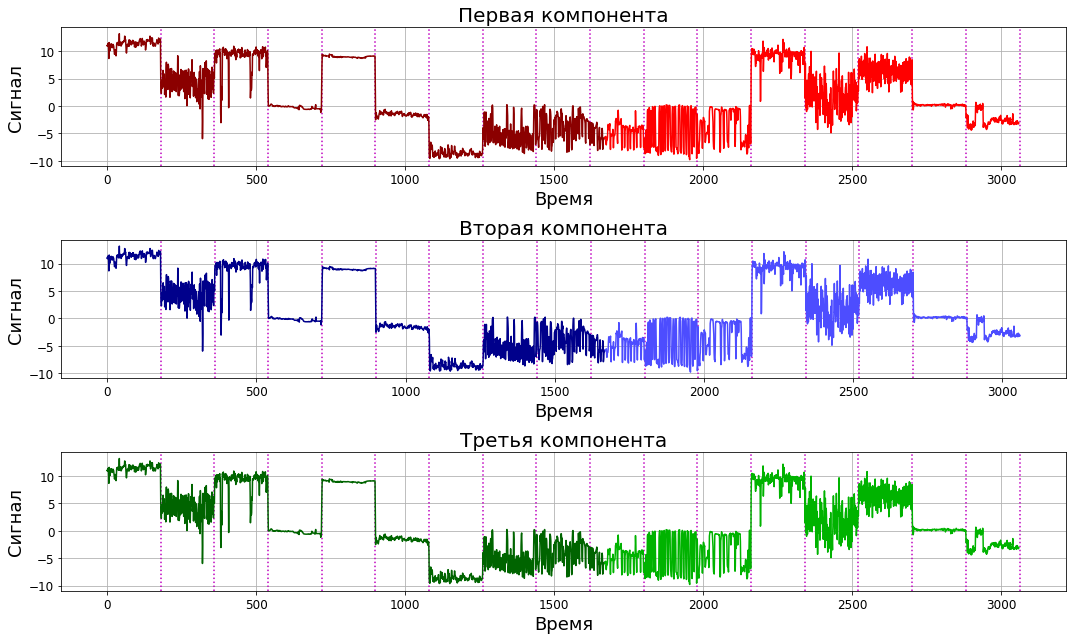

In [32]:
plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkred')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='r')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='Первая компонента', fontsize=20)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Сигнал', fontsize=18)
plt.grid()

plt.subplot(3, 1, 2)

for i in range(len(change_points) - 1):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkblue')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='#4d4dff')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='Вторая компонента', fontsize=20)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Сигнал', fontsize=18)
plt.grid()

plt.subplot(3, 1, 3)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkgreen')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='#00b300')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='Третья компонента', fontsize=20)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Сигнал', fontsize=18)
plt.grid()

plt.tight_layout()
plt.savefig('images/WISDM.png')

### Контрастный метод

#### С линейным классом

In [33]:
p = 1

#--------------------------------------------------------------
# Шаг 1: настройка критического значения на стационарной части
#--------------------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_linear(ds, p, design='multivariate', delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Критическое значение
z_lin = 0.6 * np.max(S_stationary)
print('Критическое значение:', z_lin)


#--------------------------------------------------------------
# Шаг 2: пропускаем валидационную часть, так как нет
# параметров, которые нужно настраивать
#--------------------------------------------------------------

# Моменты разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]


#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_lin = np.empty(0)

change_points_lin = []

delays_lin = np.empty(0)
current_change_point_ind = 0
false_alarms_lin = 0

st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_lin, new_st_lin = compute_test_stat_linear(data_test[st_lin + 1:], p,\
                                                     design='multivariate', threshold=z_lin, delta_max=50)

    S_lin = np.append(S_lin, new_S_lin)

    if new_st_lin >= 0:
        st_lin += new_st_lin
        change_points_lin += [int(st_lin)]
    else:
        change_points_lin += [int(data_test.shape[0] - 1)]

print('Обнаруженные моменты разладки:', change_points_lin)
    
false_alarms_lin, mean_delay_lin, std_delay_lin, not_detected_lin\
= compute_delays(change_points_test, change_points_lin)

print('Линейный класс. Число ложных срабатываний:', false_alarms_lin,\
      '; средняя задержка обнаружения:', np.round(mean_delay_lin, 4), '±', np.round(std_delay_lin, 4),\
      '; необнаруженных разладок:', not_detected_lin)

Критическое значение: 28.425647953623027
Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные моменты разладки: [148, 375, 506, 703, 878, 1055, 1235, 1389]
Линейный класс. Число ложных срабатываний: 0 ; средняя задержка обнаружения: 28.7143 ± 15.3503 ; необнаруженных разладок: 0


#### С классом нейронных сетей

In [34]:
#--------------------------------------------------------------
# Шаг 1: настройка критического значения на стационарной части
#--------------------------------------------------------------
        
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_nn(ds, n_epochs=20, delta_max=50)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z_nn = 0.45 * np.max(S_stationary)
print('Критическое значение:', z_nn)


#--------------------------------------------------------------
# Шаг 2: пропускаем валидационную часть, так как нет
# параметров, которые нужно настраивать
#--------------------------------------------------------------

# Моменты разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]


#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_nn = np.empty(0)

change_points_nn = []

delays_nn = np.empty(0)
current_change_point_ind = 0
false_alarms_nn = 0

st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_nn, new_st_nn = compute_test_stat_nn(data_test[st_nn + 1:], threshold=z_nn, n_epochs=20, delta_max=50)

    S_nn = np.append(S_nn, new_S_nn)

    if new_st_nn >= 0:
        st_nn += new_st_nn
        change_points_nn += [int(st_nn)]
    else:
        change_points_nn += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_nn)
    
false_alarms_nn, mean_delay_nn, std_delay_nn, not_detected_nn\
= compute_delays(change_points_test, change_points_nn)

print('Нейронная сеть. Число ложных срабатываний:', false_alarms_nn,\
      '; средняя задержка обнаружения:', np.round(mean_delay_nn, 4), '±', np.round(std_delay_nn, 4),\
      '; необнаруженных разладок:', not_detected_nn)

Критическое значение: 6.7982455156714074
Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [157, 310, 403, 491, 1050, 1366, 1389]
Нейронная сеть. Число ложных срабатываний: 1 ; средняя задержка обнаружения: 93.0 ± 73.4827 ; необнаруженных разладок: 2


### KLIEP

In [35]:
# Список гиперпараметров
sigma_list = [10, 20, 25, 40, 50]

# Разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Моменты разладок на валидационной части:', change_points_val)
    
# Настройка гиперпараметра 
for sigma in sigma_list:
    
    #--------------------------------------------------------------
    # Шаг 1: настройка критического значения на стационарной части
    #--------------------------------------------------------------    

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_divergence_test_stat(ds, window_size=50, sigma=sigma, method='kliep')
        S_stationary = np.append(S_stationary, S)
        
    # Критическое значение
    z = np.max(S_stationary)
    print(z)
    
    #--------------------------------------------------------------
    # Шаг 2: обнаружение разладок на валидационной части
    #--------------------------------------------------------------

    # Инициализация
    S_kliep = np.empty(0)

    change_points_kliep = []

    delays_kliep = np.empty(0)
    current_change_point_ind = 0
    false_alarms_kliep = 0

    st_kliep = 0
    new_st_kliep = 0
    
    while new_st_kliep >= 0:

        # Запустить алгоритм до момента обнаружения разладки
        new_S_kliep, new_st_kliep = compute_divergence_test_stat(data_val[st_kliep + 1:],\
                                                                 window_size=50, sigma=sigma, threshold=z,\
                                                                 method='kliep')

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            change_points_kliep += [int(st_kliep)]
        else:
            change_points_kliep += [int(data_val.shape[0] - 1)]

    false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
    = compute_delays(change_points_val, change_points_kliep)

    print('KLIEP, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_kliep,\
          '; средняя задержка обнаружения:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
          '; необнаруженных разладок:', not_detected_kliep)

Моменты разладок на валидационной части: [ 180  360  540  720  900 1080 1260 1440 1620]
1.1226241564393762
KLIEP, параметр = 10 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 9.0 ± 4.397 ; необнаруженных разладок: 0
1.0265055650087458
KLIEP, параметр = 20 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 10.7778 ± 9.8068 ; необнаруженных разладок: 0
1.0181153636922238
KLIEP, параметр = 25 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 11.4444 ± 7.6174 ; необнаруженных разладок: 0
1.008775462740808
KLIEP, параметр = 40 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 11.5556 ± 5.6196 ; необнаруженных разладок: 0
1.003945652800203
KLIEP, параметр = 50 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 10.7778 ± 9.8294 ; необнаруженных разладок: 0


In [36]:
#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

z_kliep = 1.1226241564393762
sigma = 10
    
# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_kliep = np.empty(0)

change_points_kliep = []

delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_kliep, new_st_kliep = compute_divergence_test_stat(data_test[st_kliep + 1:],\
                                                             window_size=50, sigma=sigma, threshold=z_kliep,
                                                             method='kliep')

    S_kliep = np.append(S_kliep, new_S_kliep)

    if new_st_kliep >= 0:
        st_kliep += new_st_kliep
        change_points_kliep += [int(st_kliep)]
    else:
        change_points_kliep += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_kliep)
    
false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
= compute_delays(change_points_test, change_points_kliep)

print('KLIEP, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_kliep,\
      '; средняя задержка обнаружения:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
      '; необнаруженных разладок:', not_detected_kliep)

Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [125, 228, 329, 430, 531, 682, 783, 884, 1040, 1246, 1347, 1389]
KLIEP, параметр = 10 . Число ложных срабатываний: 4 ; средняя задержка обнаружения: 34.4286 ± 27.9431 ; необнаруженных разладок: 0


### uLSIF

In [37]:
# Список гиперпараметров
sigma_list = [50, 100, 200, 250, 400, 500]

# Разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Моменты разладок на валидационной части:', change_points_val)
    
# Настройка гиперпараметра 
for sigma in sigma_list:
    
    #--------------------------------------------------------------
    # Шаг 1: настройка критического значения на стационарной части
    #--------------------------------------------------------------    

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_divergence_test_stat(ds, window_size=50, sigma=sigma, method='ulsif')
        S_stationary = np.append(S_stationary, S)
        
    # Критическое значение
    z = np.max(S_stationary)
    print(z)
    
    #--------------------------------------------------------------
    # Шаг 2: обнаружение разладок на валидационной части
    #--------------------------------------------------------------

    # Инициализация
    S_ulsif = np.empty(0)

    change_points_ulsif = []

    delays_ulsif = np.empty(0)
    current_change_point_ind = 0
    false_alarms_ulsif = 0

    st_ulsif = 0
    new_st_ulsif = 0
    
    while new_st_ulsif >= 0:

        # Запустить алгоритм до момента обнаружения разладки
        new_S_ulsif, new_st_ulsif = compute_divergence_test_stat(data_val[st_ulsif + 1:],\
                                                                 window_size=50, sigma=sigma, threshold=z,\
                                                                 method='ulsif')

        S_ulsif = np.append(S_ulsif, new_S_ulsif)

        if new_st_ulsif >= 0:
            st_ulsif += new_st_ulsif
            change_points_ulsif += [int(st_ulsif)]
        else:
            change_points_ulsif += [int(data_val.shape[0] - 1)]

    false_alarms_ulsif, mean_delay_ulsif, std_delay_ulsif, not_detected_ulsif\
    = compute_delays(change_points_val, change_points_ulsif)

    print('uLSIF, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_ulsif,\
          '; средняя задержка обнаружения:', np.round(mean_delay_ulsif, 4), '±', np.round(std_delay_ulsif, 4),\
          '; необнаруженных разладок:', not_detected_ulsif)

Моменты разладок на валидационной части: [ 180  360  540  720  900 1080 1260 1440 1620]
253.7081414340947
uLSIF, параметр = 50 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 54.8889 ± 68.2372 ; необнаруженных разладок: 2
7.236339005685235
uLSIF, параметр = 100 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 19.4444 ± 17.7833 ; необнаруженных разладок: 0
6.2689495136559445
uLSIF, параметр = 200 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 19.0 ± 17.4611 ; необнаруженных разладок: 0
6.26871647991869
uLSIF, параметр = 250 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 19.0 ± 17.4611 ; необнаруженных разладок: 0
6.268019379367395
uLSIF, параметр = 400 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 20.2222 ± 16.8376 ; необнаруженных разладок: 0
1.6599347598260592


/Users/nikita/mambaforge/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


uLSIF, параметр = 500 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 15.0 ± 11.6524 ; необнаруженных разладок: 0


In [38]:
#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

z_ulsif = 6.2689495136559445
sigma = 200
    
# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_ulsif = np.empty(0)

change_points_ulsif = []

delays_ulsif = np.empty(0)
current_change_point_ind = 0
false_alarms_ulsif = 0

st_ulsif = 0
new_st_ulsif = 0
    
while new_st_ulsif >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_ulsif, new_st_ulsif = compute_divergence_test_stat(data_test[st_ulsif + 1:],\
                                                             window_size=50, sigma=sigma, threshold=z_ulsif,
                                                             method='ulsif')

    S_ulsif = np.append(S_ulsif, new_S_ulsif)

    if new_st_ulsif >= 0:
        st_ulsif += new_st_ulsif
        change_points_ulsif += [int(st_ulsif)]
    else:
        change_points_ulsif += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_ulsif)
    
false_alarms_ulsif, mean_delay_ulsif, std_delay_ulsif, not_detected_ulsif\
= compute_delays(change_points_test, change_points_ulsif)

print('uLSIF, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_ulsif,\
      '; средняя задержка обнаружения:', np.round(mean_delay_ulsif, 4), '±', np.round(std_delay_ulsif, 4),\
      '; необнаруженных разладок:', not_detected_ulsif)

Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [137, 381, 498, 711, 899, 1063, 1225, 1333, 1389]
uLSIF, параметр = 200 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 30.7143 ± 22.0889 ; необнаруженных разладок: 0


### RuLSIF

In [39]:
# Список гиперпараметров
sigma_list = [0.2, 0.5, 1, 2, 5, 10, 20, 25, 40, 50, 100, 200]

# Разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Моменты разладок на валидационной части:', change_points_val)
    
# Настройка гиперпараметра 
for sigma in sigma_list:
    
    #--------------------------------------------------------------
    # Шаг 1: настройка критического значения на стационарной части
    #--------------------------------------------------------------    

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_divergence_test_stat(ds, window_size=50, sigma=sigma, method='rulsif')
        S_stationary = np.append(S_stationary, S)
        
    # Критическое значение
    z = np.max(S_stationary)
    print(z)
    
    #--------------------------------------------------------------
    # Шаг 2: обнаружение разладок на валидационной части
    #--------------------------------------------------------------

    # Инициализация
    S_rulsif = np.empty(0)

    change_points_rulsif = []

    delays_rulsif = np.empty(0)
    current_change_point_ind = 0
    false_alarms_rulsif = 0

    st_rulsif = 0
    new_st_rulsif = 0
    
    while new_st_rulsif >= 0:

        # Запустить алгоритм до момента обнаружения разладки
        new_S_rulsif, new_st_rulsif = compute_divergence_test_stat(data_val[st_rulsif + 1:],\
                                                                 window_size=50, sigma=sigma, threshold=z,\
                                                                 method='rulsif')

        S_rulsif = np.append(S_rulsif, new_S_rulsif)

        if new_st_rulsif >= 0:
            st_rulsif += new_st_rulsif
            change_points_rulsif += [int(st_rulsif)]
        else:
            change_points_rulsif += [int(data_val.shape[0] - 1)]

    false_alarms_rulsif, mean_delay_rulsif, std_delay_rulsif, not_detected_rulsif\
    = compute_delays(change_points_val, change_points_rulsif)

    print('RuLSIF, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_rulsif,\
          '; средняя задержка обнаружения:', np.round(mean_delay_rulsif, 4), '±', np.round(std_delay_rulsif, 4),\
          '; необнаруженных разладок:', not_detected_rulsif)

Моменты разладок на валидационной части: [ 180  360  540  720  900 1080 1260 1440 1620]
0.4997277198406665
RuLSIF, параметр = 0.2 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 61.3333 ± 42.3661 ; необнаруженных разладок: 1
0.48635144977639844
RuLSIF, параметр = 0.5 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 58.5556 ± 43.9851 ; необнаруженных разладок: 1
0.45423682306631347
RuLSIF, параметр = 1 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 55.7778 ± 45.0278 ; необнаруженных разладок: 1
0.4335008506539043
RuLSIF, параметр = 2 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 40.4444 ± 10.6782 ; необнаруженных разладок: 0
0.34983315606276705
RuLSIF, параметр = 5 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 33.5556 ± 9.4412 ; необнаруженных разладок: 0
0.34004935653367135
RuLSIF, параметр = 10 . Число ложных срабатываний: 0 ; средняя задержка обнаружения: 35.3333 ± 9.6494 ; необнаруженных разладок: 0
0.334

In [40]:
#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

z_rulsif = 0.34983315606276705
sigma = 5
    
# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_rulsif = np.empty(0)

change_points_rulsif = []

delays_rulsif = np.empty(0)
current_change_point_ind = 0
false_alarms_rulsif = 0

st_rulsif = 0
new_st_rulsif = 0
    
while new_st_rulsif >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_rulsif, new_st_rulsif = compute_divergence_test_stat(data_test[st_rulsif + 1:],\
                                                             window_size=50, sigma=sigma, threshold=z_rulsif,
                                                             method='rulsif')

    S_rulsif = np.append(S_rulsif, new_S_rulsif)

    if new_st_rulsif >= 0:
        st_rulsif += new_st_rulsif
        change_points_rulsif += [int(st_rulsif)]
    else:
        change_points_rulsif += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_rulsif)
    
false_alarms_rulsif, mean_delay_rulsif, std_delay_rulsif, not_detected_rulsif\
= compute_delays(change_points_test, change_points_rulsif)

print('RuLSIF, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_rulsif,\
      '; средняя задержка обнаружения:', np.round(mean_delay_rulsif, 4), '±', np.round(std_delay_rulsif, 4),\
      '; необнаруженных разладок:', not_detected_rulsif)

Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [144, 356, 457, 712, 882, 1069, 1251, 1389]
RuLSIF, параметр = 5 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 55.1429 ± 51.8802 ; необнаруженных разладок: 1


### M-статистика

In [41]:
# Список гиперпараметров
sigma_list = [10, 20, 25, 40, 50]

# Разладки на валидационной части
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Моменты разладок на валидационной части:', change_points_val)
    
# Настройка гиперпараметра 
for sigma in sigma_list:
    
    #--------------------------------------------------------------
    # Шаг 1: настройка критического значения на стационарной части
    #--------------------------------------------------------------    

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Критическое значение
    z = np.max(S_stationary)
    print(z)
    
    #--------------------------------------------------------------
    # Шаг 2: обнаружение разладок на валидационной части
    #--------------------------------------------------------------

    # Инициализация
    S_mmd = np.empty(0)

    change_points_mmd = []

    delays_mmd = np.empty(0)
    current_change_point_ind = 0
    false_alarms_mmd = 0

    st_mmd = 0
    new_st_mmd = 0
    
    while new_st_mmd >= 0:

        # Запустить алгоритм до момента обнаружения разладки
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            change_points_mmd += [int(st_mmd)]
        else:
            change_points_mmd += [int(data_val.shape[0] - 1)]

    false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
    = compute_delays(change_points_val, change_points_mmd)

    print('M-статистика, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_mmd,\
          '; средняя задержка обнаружения:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
          '; необнаруженных разладок:', not_detected_mmd)

Моменты разладок на валидационной части: [ 180  360  540  720  900 1080 1260 1440 1620]
5.217594927197018
M-статистика, параметр = 10 . Число ложных срабатываний: 2 ; средняя задержка обнаружения: 13.7778 ± 15.0095 ; необнаруженных разладок: 0
1.7284497814725275
M-статистика, параметр = 20 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.1111 ± 8.7996 ; необнаруженных разладок: 0
1.1237385679629701
M-статистика, параметр = 25 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.1111 ± 8.7996 ; необнаруженных разладок: 0
0.44657933683968337
M-статистика, параметр = 40 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.1111 ± 8.7996 ; необнаруженных разладок: 0
0.2869555417166241
M-статистика, параметр = 50 . Число ложных срабатываний: 1 ; средняя задержка обнаружения: 9.1111 ± 8.7996 ; необнаруженных разладок: 0


In [42]:
#--------------------------------------------------------------
# Шаг 3: обнаружение разладок на тестовой части
#--------------------------------------------------------------

z_mmd = 1.7284497814725275
sigma = 20
    
# Разладки на тестовой части
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Моменты разладок на тестовой части:', change_points_test)

# Инициализация
S_mmd = np.empty(0)

change_points_mmd = []

delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Запустить алгоритм до момента обнаружения разладки
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd + 1:],\
                                                      window_size=50, sigma=sigma, threshold=z_mmd)

    S_mmd = np.append(S_mmd, new_S_mmd)

    if new_st_mmd >= 0:
        st_mmd += new_st_mmd
        change_points_mmd += [int(st_mmd)]
    else:
        change_points_mmd += [int(data_test.shape[0] - 1)]

print('Обнаруженные разладки:', change_points_mmd)
    
false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
= compute_delays(change_points_test, change_points_mmd)

print('M-статистика, параметр =', sigma, '. Число ложных срабатываний:', false_alarms_mmd,\
      '; средняя задержка обнаружения:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
      '; необнаруженных разладок:', not_detected_mmd)

Моменты разладок на тестовой части: [ 131  311  491  671  851 1032 1212]
Обнаруженные разладки: [121, 226, 327, 428, 529, 681, 782, 883, 1039, 1229, 1330, 1389]
M-статистика, параметр = 20 . Число ложных срабатываний: 4 ; средняя задержка обнаружения: 30.7143 ± 28.2424 ; необнаруженных разладок: 0


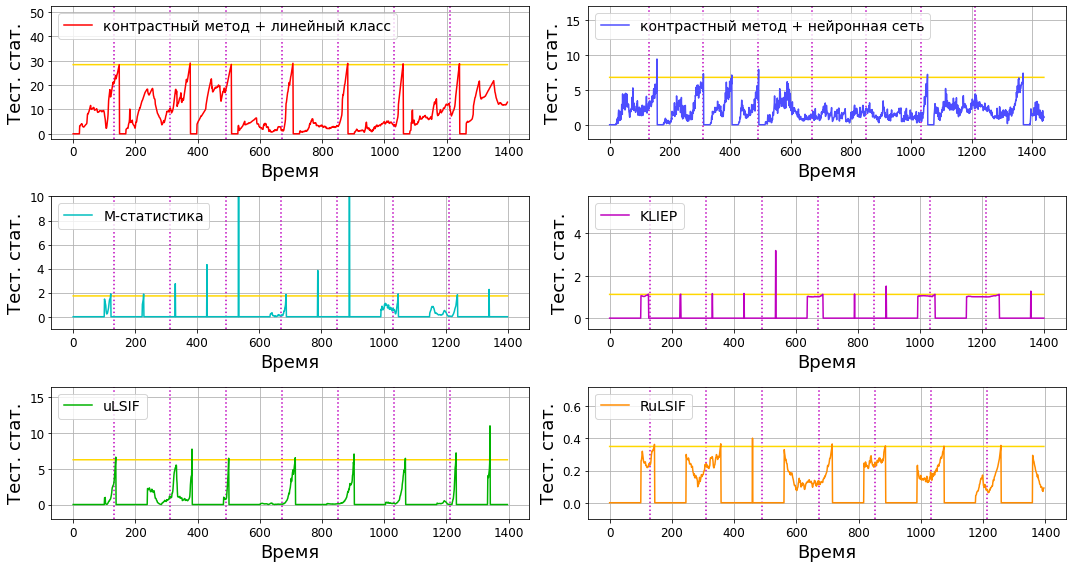

In [43]:
plt.figure(figsize=(15, 8))


plt.subplot(3, 2, 1)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')

plt.plot(np.arange(len(S_lin)), [z_lin] * len(S_lin), c='gold')
plt.plot(np.arange(len(S_lin)), S_lin, c='r', label='контрастный метод + линейный класс')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.grid()
plt.ylim((-2, 1.8 * np.max(S_lin)))

plt.subplot(3, 2, 2)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_nn)), [z_nn] * len(S_nn), c='gold')
plt.plot(np.arange(len(S_nn)), S_nn, c='#4d4dff', label='контрастный метод + нейронная сеть')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-2, 1.8 * np.max(S_nn)))
plt.grid()

plt.subplot(3, 2, 3)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_mmd)), [z_mmd] * len(S_mmd), c='gold')
plt.plot(np.arange(len(S_mmd)), S_mmd, c='c', label='M-статистика')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-1, 10))
plt.grid()

plt.subplot(3, 2, 4)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_kliep)), [z_kliep] * len(S_kliep), c='gold')
plt.plot(np.arange(len(S_kliep)), S_kliep, c='m', label='KLIEP')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-0.5, 1.8 * np.max(S_kliep)))
plt.grid()

plt.subplot(3, 2, 5)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_ulsif)), [z_ulsif] * len(S_ulsif), c='gold')
plt.plot(np.arange(len(S_ulsif)), S_ulsif, c='#00b300', label='uLSIF')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-2, 1.5 * np.max(S_ulsif)))
plt.grid()

plt.subplot(3, 2, 6)

for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_rulsif)), [z_rulsif] * len(S_rulsif), c='gold')
plt.plot(np.arange(len(S_rulsif)), S_rulsif, c='darkorange', label='RuLSIF')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Время', fontsize=18)
plt.ylabel('Тест. стат.', fontsize=18)
plt.ylim((-0.1, 1.8 * np.max(S_rulsif)))
plt.grid()

plt.tight_layout()

plt.savefig('images/WISDM_results.png')